# Linear least squares fit

Solve the tasks below.
For each task, give reasons for your solution by commenting in the notebook.
In conclusion, summarize your findings and contextualize them. What have you learned? Do the results make sense?

Your results will be examined for plagiarism. Please use your own plot styles, articulate your own thoughts, and present your own experimental approaches.

## Tasks

Perform a least squares fit of a parabola of third order

$$ y(x) = \theta_0 + \theta_1 x + \theta_2 x^2 + \theta_3 x^3 $$

for the thirteen independent measurments $(x_i, y_i)$ given by $(-1.5, -8.0 \pm 2.5)$, $(-1.25, -2.5 \pm 2.0)$, $(-1.0, -1.5 \pm 1.5)$, $(-0.75, 1.0 \pm 1.0)$, $(-0.5, 4.0 \pm 1.0)$, $(-0.25, 4.0 \pm 0.5)$, $(0.0, 5.5 \pm 0.5)$, $(0.25, 4.5 \pm 0.5)$, $(0.5, 5.5 \pm 0.5)$, $(0.75, 3.0 \pm 1.0)$, $(1.0, 3.0 \pm 1.0)$, $(1.25, 4.5 \pm 1.5)$, $(1.5, 7.0 \pm 2.0)$. 

a) Determine the best fit parameters $\hat \theta_i$ and their covariances using the formula for linear least squares fits.

b) Determine the $\chi_\mathrm{obs}^2$ for the best fit parameter. What is the number of degrees of freedom? Plot the $\chi^2$ distribution and indicate $\chi_\mathrm{obs}^2$ in this plot (e.g. by drawing a line at this value).
What is the $p$-value for this fit?

c) Plot the fitted parabola and the $1\sigma$ error band around it as obtaind from the error propagation formula $\sigma_y^2 = A^\mathrm{T} U A$. What is the predicted value $y$ at $x=1$ and its uncertainty?

d) Compare the fit result and the covariance matrix with the results obtained with iminuit. Do the results agree?

e) Plot the data with a straight-line fit. Determine the $p$-value for this straight-line fit. Is this an acceptable description of the data?

f) How does the $p$-value for a straight-line fit change if the error bars are twice as high in this example? Would you say the fit is describing the data well in this case?


### Hints

1) The following numpy functions might come in very handy
* diagonal matrix from vector v in numpy: *A = np.diagflat(v)*
* matrix from column vectors v0, v1, v2, v3: *A = np.column_stack((v0, v1, v2, v3))*
* multiplication of matrices A and B in numpy: *C = A.dot(B)*
* transposed matrix: *A_T = np.transpose(A)*
* inverse matrix: *A_inv = inv(A)*, this requires *from numpy.linalg import inv*

2) It might be useful to write a function which returns the uncertainty $\sigma_y$ for a numpy array of $x$ values. A function $f$ that only works for a scalar value $x$ can be vectorized (i.e., it works also for numpy arrays) with *numpy.vectorize*.

3) Data points with error bars can be drawn with *plt.errorbar(x, y, yerr=sigma_y)*

4) A band between $y$ values can be drawn with the aid of *matplotlib.pyplot.fill_between*

## Comments on Python's `iminuit`

The KIP service has iminuit version 1.3.8. Please note that the most recent version is $\geq2.0.0$ and that the [documentation](https://iminuit.readthedocs.io/en/stable/) applies to *that* version. Some backward-incompatible changes have been introduced, some of which changed some interfaces. For your tasks that mainly affects the `minuit.Minuit` constructor. The following shows the construction of a `Minuit` object for version 1.3.8 (in case you use the KIP service or a version $<2.0.0$) and $\geq2.0.0$ (in case you use another service implementing a higher version), respectively.
```python
from iminuit import Minuit

def func(par1, par2, ..., parN):
    return minimise_something(par1, par2, ..., parN)

# least squares method: errordef=1
# likelihood method: errordef=0.5
m = Minuit(func, par1=0.1, par2=0.1, ..., parN=0.1, errordef=1)
```

And this would be the equivalent workflow for versions >2.0.0
```python
from iminuit import Minuit

def func(par1, par2, ..., parN):
    return minimise_something(par1, par2, ..., parN)

# least squares method: errordef=Minuit.LEAST_SQUARES
# likelihood method: errordef=Minuit.LIKELIHOOD

# add errordef as an attribute of your defined minimisation function which will be checked for when optimised
func.errordef = Minuit.LEAST_SQUARES
m = Minuit(func, par1=0.1 par2=0.1, ..., parN=0.1)
```

Another (potenitally) Jupiter related *feature* is the fact that `m.migrad()`, `m.matrix()`, `m.minos()` etc. can yield a nice summary of the respective procedure. However, in order to show it, either of these methods (and potentially others in case you use them) have to be *the last line of a code cell*. If there is *anything* coming afterwards, the output will not be printed, hence, for anything that follows, it is recommended to start a new code cell.


## Solution

In [208]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from iminuit import Minuit

In [209]:
# data
x = np.array([-1.5,-1.25, -1., -0.75, -0.5, -0.25, 0., 0.25, 0.5, 0.75, 1.0, 1.25, 1.5])
y = np.array([-8, -2.5, -1.5, 1., 4.0, 4., 5.5, 4.5, 3.5, 3., 3., 4.5, 7.])
sigma_y = np.array([2.5, 2., 1.5, 1, 1, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.5, 2.])

a) here we use the formula $\overrightarrow{\hat{\lambda}}=\left(\mathbf{A}^{\top} \mathbf{C}^{-1} \mathbf{A}\right)^{-1} \mathbf{A}^{\top} \mathbf{C}^{-1} \vec{y}$ from the instructions. Where $\left(\mathbf{A}^{\top} \mathbf{C}^{-1} \mathbf{A}\right)^{-1}$ is the covariance matrix.


In [210]:
def parabola(a, b, c, d, x):
    return a + b * x + c * x**2 + d * x**3

A = np.column_stack((np.ones_like(x), x, x**2, x**3))
C = np.diagflat(sigma_y**2)

A_T = np.transpose(A)
C_inv = inv(C)

cov = inv(A_T.dot(C_inv).dot(A))
theta = cov.dot(A_T.dot(C_inv).dot(y))

print("Covariance matrix:\n", cov)
print("Fitted parameters:\n", theta)
print("Variances of parameters:\n", np.diag(cov))

Covariance matrix:
 [[ 0.06856352 -0.03260524 -0.06914669  0.02439339]
 [-0.03260524  0.48237957  0.00726321 -0.32047483]
 [-0.06914669  0.00726321  0.24388868 -0.04381973]
 [ 0.02439339 -0.32047483 -0.04381973  0.32929519]]
Fitted parameters:
 [ 4.55056569 -0.43054409 -2.95912686  2.40936812]
Variances of parameters:
 [0.06856352 0.48237957 0.24388868 0.32929519]


b)

In [211]:
#calculate expected values from parameters
y_dach = parabola(*theta, x)

chi2_obs = (y-y_dach).T.dot(C_inv).dot(y-y_dach) 

#the degrees of freedom follow the number of measurements minus the number of parameters
dof = len(x) - len(theta)

print("Chi-squared:", chi2_obs)
print("Degrees of freedom:", dof)



Chi-squared: 9.764492802888006
Degrees of freedom: 9


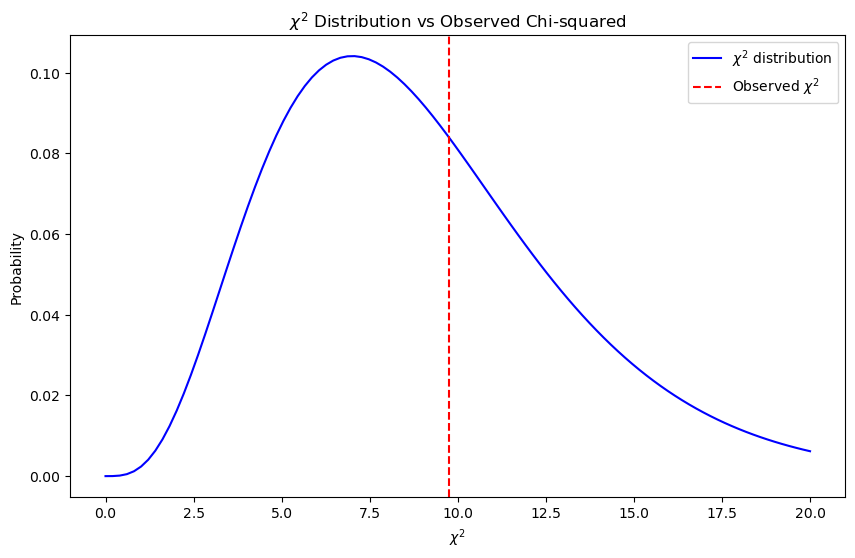

In [212]:
from scipy.stats import chi2
#the chi2 distribution is plotted using scipy
chi2_space = np.linspace(0, 20, 100)
chi2_pdf = chi2.pdf(chi2_space, dof)
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(chi2_space, chi2_pdf, label=r'$\chi^2$ distribution', color='blue')
plt.title(r'$\chi^2$ Distribution vs Observed Chi-squared')
plt.xlabel(r'$\chi^2$')
plt.ylabel('Probability')
plt.axvline(chi2_obs, color='red', linestyle='--', label=r'Observed $\chi^2$')
plt.legend()
plt.show()

In [213]:
#p value
p_value = 1 - chi2.cdf(chi2_obs, dof)
print("p-value:", p_value)

p-value: 0.3698852535608802


c)

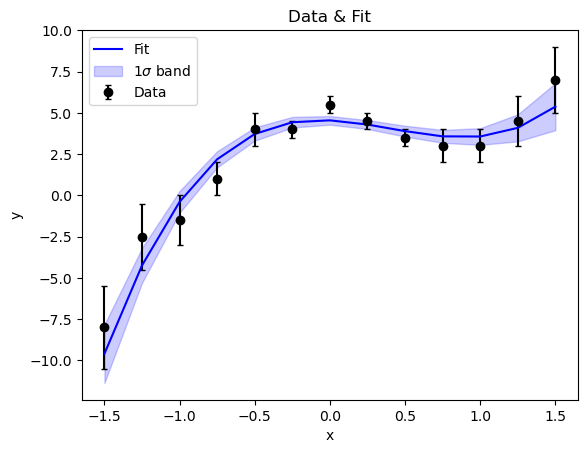

In [214]:
#Calculate the one-sigma band as given in the instructions
sigma_sq = np.diag(A.dot(cov).dot(A_T))
sigma = np.sqrt(sigma_sq)

#plot the parabola and the one-sigma band
plt.errorbar(x, y, yerr=sigma_y, fmt='o', label='Data', color='black', capsize=2)
plt.plot(x, y_dach, label='Fit', color='blue')
plt.fill_between(x, y_dach - sigma, y_dach + sigma, 
                color='blue', alpha=0.2, label=r'1$\sigma$ band')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data & Fit')
plt.legend()
plt.show()

In [215]:
#predict value and error for x=1
y_x1 = parabola(*theta, 1)
sigma_x1 = np.sqrt(A[9].dot(cov).dot(np.transpose(A[9])))
print("Predicted value at x=1:", y_x1)
print("Uncertainty at x=1:", sigma_x1)
print("Measurement at x=1:", y[9])
print("Measurement error at x=1:", sigma_y[9])



Predicted value at x=1: 3.570262852445693
Uncertainty at x=1: 0.3899897806059734
Measurement at x=1: 3.0
Measurement error at x=1: 1.0


d)

In [216]:
def func(a, b, c, d):
    return np.sum((y - parabola(a, b, c, d, x))**2 / sigma_y**2)

func.errordef = Minuit.LEAST_SQUARES
m = Minuit(func, a=0, b=0, c=0, d=0)
m.migrad()

print("Minuit results: ", m.values['a'], m.values['b'], m.values['c'], m.values['d'])
print("Fit results: ", theta[0], theta[1], theta[2], theta[3])
#results align very well
print("Minuit covariance matrix:\n", m.covariance)
print("Fit covariance matrix:\n", cov)
#these also align

Minuit results:  4.550565689723195 -0.43054409368375374 -2.959126863900166 2.409368120306413
Fit results:  4.550565689723275 -0.4305440936840075 -2.959126863900232 2.409368120306658
Minuit covariance matrix:
 ┌───┬─────────────────────────────┐
│   │      a      b      c      d │
├───┼─────────────────────────────┤
│ a │ 0.0686  -0.03  -0.07   0.02 │
│ b │  -0.03  0.482   0.01  -0.32 │
│ c │  -0.07   0.01  0.244  -0.04 │
│ d │   0.02  -0.32  -0.04  0.329 │
└───┴─────────────────────────────┘
Fit covariance matrix:
 [[ 0.06856352 -0.03260524 -0.06914669  0.02439339]
 [-0.03260524  0.48237957  0.00726321 -0.32047483]
 [-0.06914669  0.00726321  0.24388868 -0.04381973]
 [ 0.02439339 -0.32047483 -0.04381973  0.32929519]]


e) straight line fit

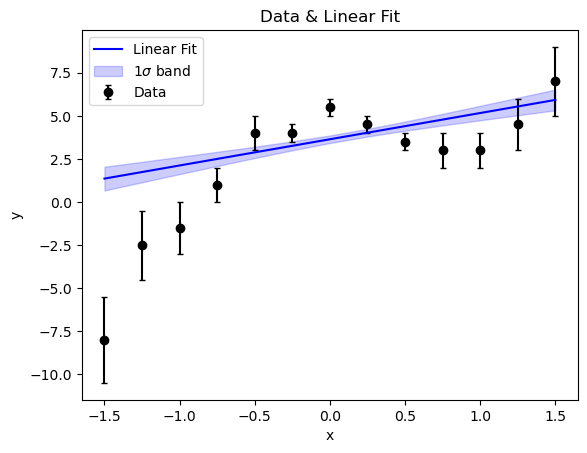

Chi-squared for linear fit: 56.63711850163011
p-value for linear fit: 3.8805105018191455e-08


In [217]:
#similar to before, we do the fit. This we only use a linear function as seen in A
A_line = np.column_stack((np.ones_like(x), x))
cov_line = inv(A_line.T.dot(C_inv).dot(A_line))
theta_line = cov_line.dot(A_line.T.dot(C_inv).dot(y))
# Plotting the linear fit
plt.errorbar(x, y, yerr=sigma_y, fmt='o', label='Data', color='black', capsize=2)
plt.plot(x, A_line.dot(theta_line), label='Linear Fit', color='blue')
#add error band
sigma_sq_line = A_line.dot(cov_line).dot(A_line.T)
plt.fill_between(x, A_line.dot(theta_line) - np.sqrt(np.diag(sigma_sq_line)), 
                 A_line.dot(theta_line) + np.sqrt(np.diag(sigma_sq_line)), 
                 color='blue', alpha=0.2, label=r'1$\sigma$ band')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data & Linear Fit')
plt.legend()
plt.show()

# Calculate the chi-squared for the linear fit
y_line_dach = A_line.dot(theta_line)
chi2_line = np.sum(((y - y_line_dach) / sigma_y) ** 2)
print("Chi-squared for linear fit:", chi2_line)
# Calculate the p-value for the linear fit
p_value_line = 1 - chi2.cdf(chi2_line, len(x) - len(theta_line))
print("p-value for linear fit:", p_value_line)
#you can see a significantly worse chi2 and p-value here


f) Double Error straight line fit

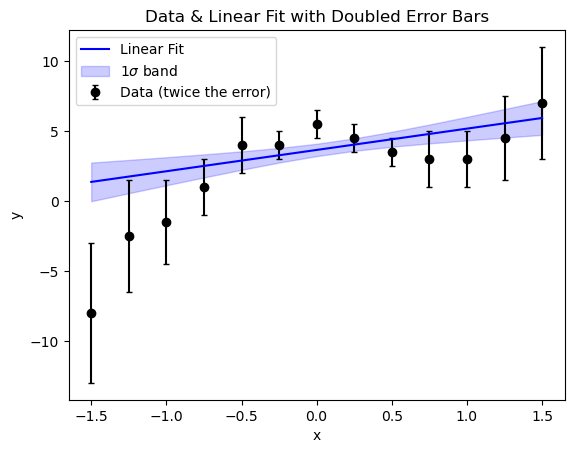

Chi-squared for linear fit with doubled errors: 14.159279625407528
p-value for linear fit with doubled errors: 0.22430487328826554


In [218]:
#and again, we do the same thing but this time with twice the errors for the measurements
sigma_y2 = 2 * sigma_y
# Recalculate the covariance matrix and fit parameters with the new errors
C2 = np.diagflat(sigma_y2**2)
C_inv2 = inv(C2)

cov_line2 = inv(A_line.T.dot(C_inv2).dot(A_line))
theta_line2 = cov_line.dot(A_line.T.dot(C_inv).dot(y))

# Plotting the linear fit with doubled errors
plt.errorbar(x, y, yerr=sigma_y2, fmt='o', label='Data (twice the error)', color='black', capsize=2)
plt.plot(x, A_line.dot(theta_line2), label='Linear Fit', color='blue')
#add error band
sigma_sq_line2 = A_line.dot(cov_line2).dot(A_line.T)
plt.fill_between(x, A_line.dot(theta_line2) - np.sqrt(np.diag(sigma_sq_line2)), 
                 A_line.dot(theta_line2) + np.sqrt(np.diag(sigma_sq_line2)), 
                 color='blue', alpha=0.2, label=r'1$\sigma$ band')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data & Linear Fit with Doubled Error Bars')
plt.legend()
plt.show()
# Calculate the chi-squared for the linear fit with doubled errors
y_line_dach2 = A_line.dot(theta_line2)
chi2_line2 = np.sum(((y - y_line_dach2) / sigma_y2) ** 2)
print("Chi-squared for linear fit with doubled errors:", chi2_line2)
# Calculate the p-value for the linear fit with doubled errors
p_value_line2 = 1 - chi2.cdf(chi2_line2, len(x) - len(theta_line2))
print("p-value for linear fit with doubled errors:", p_value_line2)
#you can see a significantly better chi2 and p-value now with the doubled errors.
#Still, the linear fit is not as good as the parabola


